# Examine and clean the data

In [56]:
import pandas as pd
df = pd.read_csv('datasets/RestaurantVisitors.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.index.freq = 'D'
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [57]:
df = df.dropna()
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [58]:
cols = ['rest1', 'rest2', 'rest3', 'rest4', 'total']
for column in cols:
    df[column] = df[column].astype(int)

# Plot the data

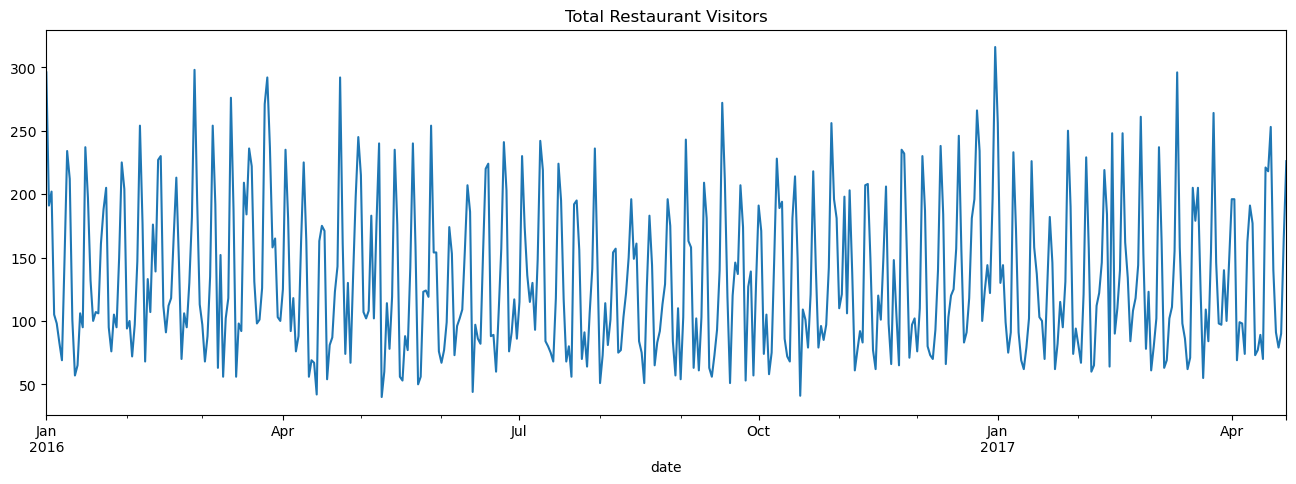

In [77]:
import matplotlib.pyplot as plt

df['total'].plot(figsize=(16, 5))
plt.title('Total Restaurant Visitors')
plt.show()

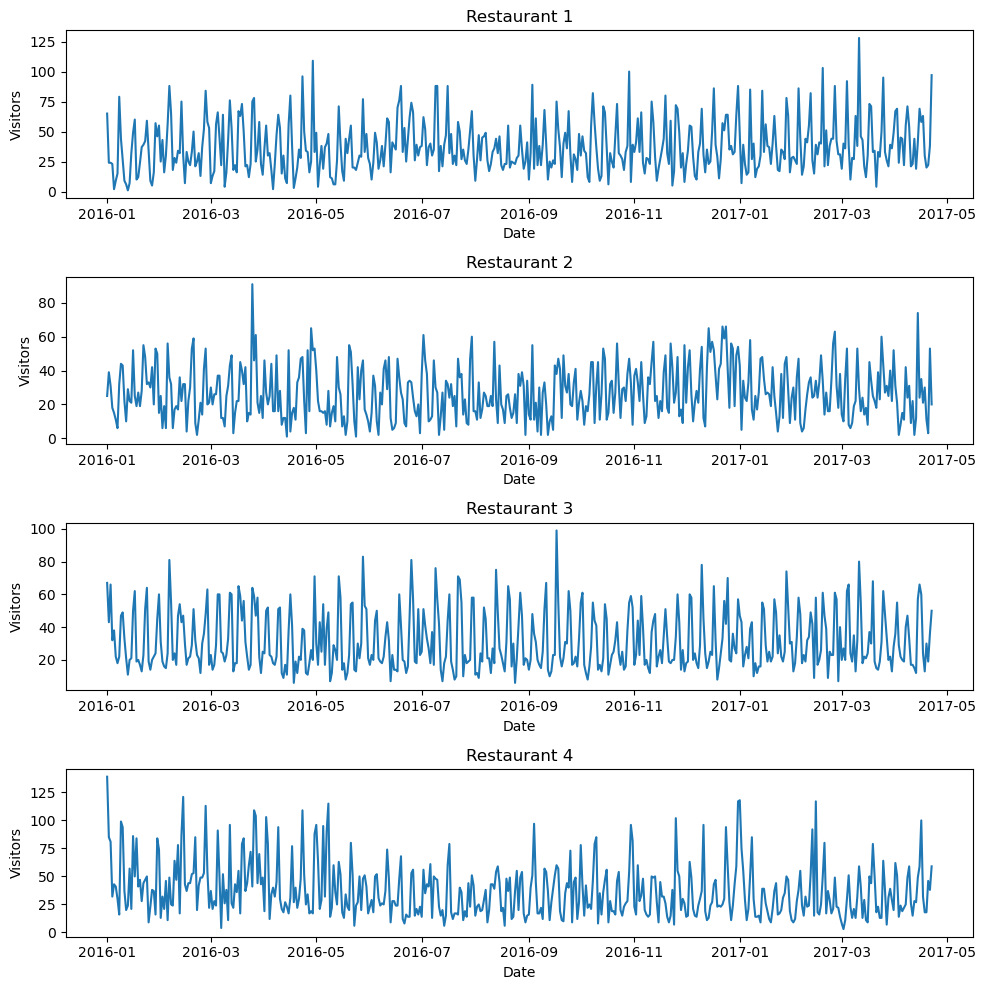

In [38]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

for i in range(4):
    axs[i].plot(df[f'rest{i+1}'])
    axs[i].set_title(f'Restaurant {i+1}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Visitors')

fig.tight_layout()

plt.show()

Hypothesis: the data should exhibit mostly weekly seasonality

# Check the data for a weekly trend

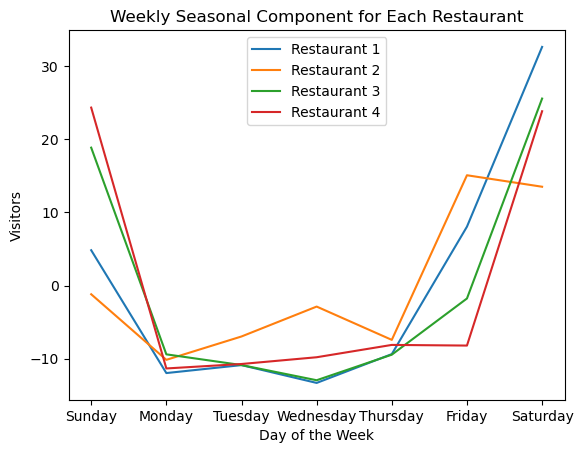

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(4):
    weekly_decomp = seasonal_decompose(df[f'rest{i+1}'], model='additive', period=7)
    last_7_seasonal = weekly_decomp.seasonal.tail(7)
    last_7_weekday = df['weekday'].tail(7)
    plt.plot(last_7_weekday, last_7_seasonal, label=f'Restaurant {i+1}')

plt.legend()
plt.title('Weekly Seasonal Component for Each Restaurant')
plt.xlabel('Day of the Week')
plt.ylabel('Visitors')
plt.show()

A clear weekly trend can be identified, people go the the restaurants the most on saturday. 

# Find the optimal order for each model using auto arima

In [40]:
from pmdarima import auto_arima

orders = {}
seasonal_orders = {}

for col in cols:
    model = auto_arima(df[col], seasonal=True, m=7, trace=True, suppress_warnings=True)
    orders[col] = model.order
    seasonal_orders[col] = model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4498.869, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4282.164, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4496.872, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=4459.994, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=4233.491, Time=0.30 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=4124.750, Time=0.35 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=4354.529, Time=0.12 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=4324.385, Time=0.40 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4288.103, Time=0.21 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.56 s

# Split the data into a train and test set, fit the models to the data and make predictions.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = df.iloc[:-12]
test = df.iloc[-12:]

models = {}
for col in cols:
    models[col] = SARIMAX(train[col], order=orders[col], exog=train['holiday'], seasonal_order=seasonal_orders[col]).fit()

In [60]:
predictions = {}
for col, model in models.items():
    predictions[col] = model.predict(start=len(train), end=len(train)+len(test)-1, exog=test['holiday'], dynamic=False)

# Plot the predicted and actual values for all four restaurants. 

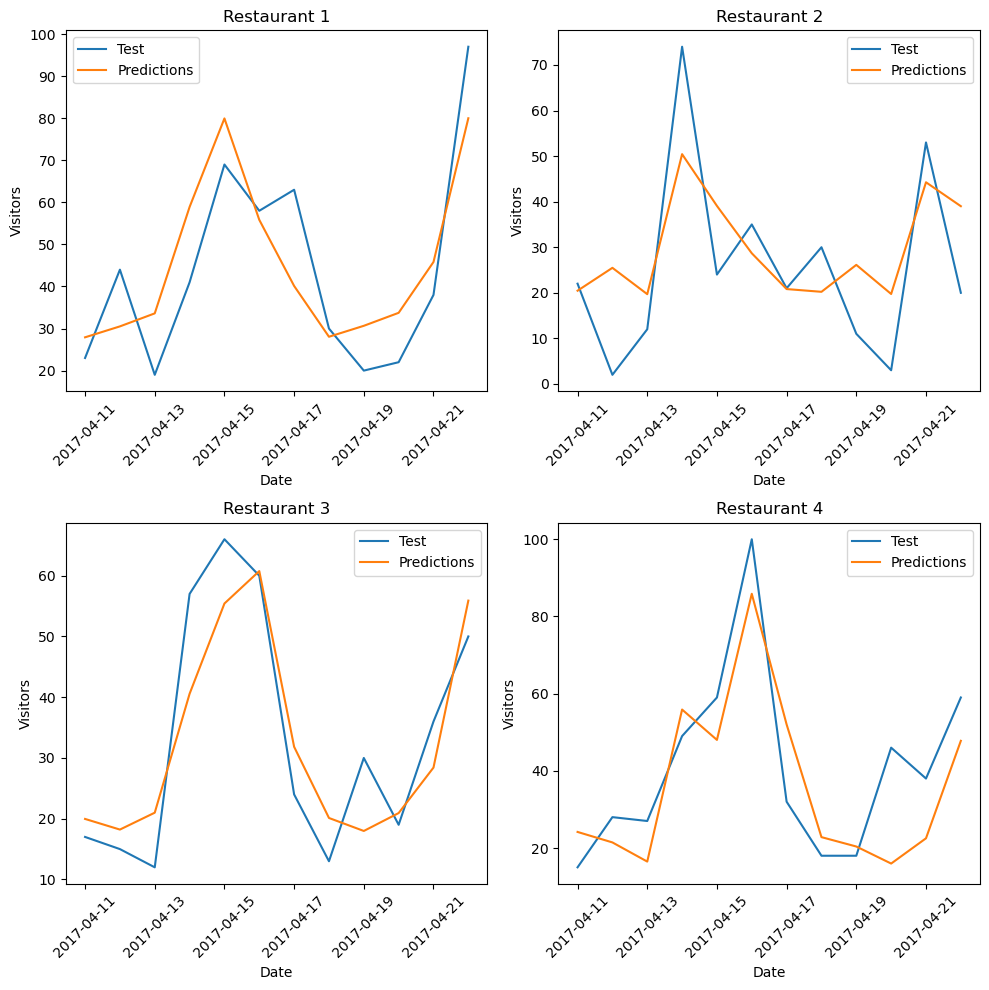

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    col = cols[i]
    axs[i//2, i%2].plot(test[col], label='Test')
    axs[i//2, i%2].plot(test.index, predictions[col], label='Predictions')
    axs[i//2, i%2].set_title(f'Restaurant {i+1}')
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Visitors')
    axs[i//2, i%2].legend()

    for tick in axs[i//2, i%2].get_xticklabels():
        tick.set_rotation(45)

fig.tight_layout()

# Compare the prediction made for total visitors and a summed prediction from the four restaurants.

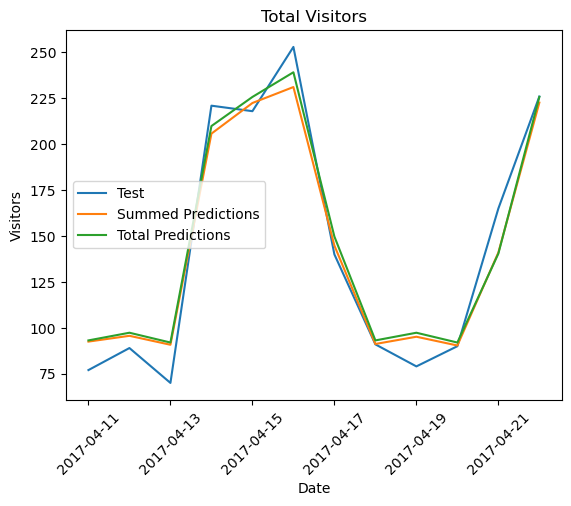

In [75]:
summed_prediction = sum([predictions[col] for col in cols[:-1]])
total_prediction = predictions['total']

plt.plot(test['total'], label='Test')
plt.plot(test.index, summed_prediction, label='Summed Predictions')
plt.plot (test.index, total_prediction, label='Total Predictions')
plt.title('Total Visitors')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.legend()

for tick in plt.gca().get_xticklabels():
    tick.set_rotation(45)

# Evaluate the predictions

In [74]:
from sklearn.metrics import mean_absolute_percentage_error
print('Total prediction MAPE:', mean_absolute_percentage_error(test['total'], total_prediction)*100)
print('Summed prediction MAPE:', mean_absolute_percentage_error(test['total'], summed_prediction)*100)

Total prediction MAPE: 10.462432717133037
Summed prediction MAPE: 9.61850691864844


Summed predictions provides more accurate results than the prediction made for total customer visits. 